In [1]:
!pip install segmentation_models_pytorch >> None
!pip install torchmetrics >> None

In [2]:
import torch as th
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchmetrics as M

In [3]:
def train_model(model, criterion, optimizer, metric, file_name,
                train, test, batch_size, num_epoch):
    th.manual_seed(42)
    device = th.device('cuda' if th.cuda.is_available() else 'cpu')

    loader      = DataLoader(train, batch_size=batch_size, shuffle=True)
    loader_test = DataLoader(test,  batch_size=batch_size, shuffle=False)

    model     = model.to(device)
    criterion = criterion.to(device)
    metric    = metric.to(device)

    best_metric  = 0.0
    epoch_losses = []
    test_metrics = []

    for epoch in range(1, num_epoch+1):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in tqdm(loader,
                                     desc=f'Train {epoch}/{num_epoch}',
                                     leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss   = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss   /= len(loader)
        epoch_losses.append(epoch_loss)

        model.eval()
        metric.reset()
        with th.no_grad():
            for X_batch, y_batch in tqdm(loader_test,
                                         desc=f'Valid {epoch}/{num_epoch}',
                                         leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                metric.update(y_pred, y_batch)
        test_metric = metric.compute().item()
        test_metrics.append(test_metric)

        if test_metric > best_metric:
            best_metric = test_metric
            th.save(model.state_dict(), file_name)

        tqdm.write(
            f"Epoch {epoch}/{num_epoch} — "
            f"train loss: {epoch_losses[-1]:.4f}, "
            f"val score: {test_metrics[-1]:.4f}"
        )

    return epoch_losses, test_metrics

# Задача 1

Обучите модель u-net семантической сегментации на встроенном в torchvision датасете Pascal VOC с VGG в качестве энкодера

In [4]:
batch_size = 16
num_epochs = 5
learning_rate = 1e-3
file_name = 'best_unet_vgg16.pth'

In [5]:
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0).long()),
])

In [6]:
train_ds = VOCSegmentation(
    root='./data', year='2012', image_set='train',
    download=True,
    transform=img_transform,
    target_transform=mask_transform,
)
test_ds = VOCSegmentation(
    root='./data', year='2012', image_set='val',
    download=False,
    transform=img_transform,
    target_transform=mask_transform,
)

In [7]:
model = smp.Unet(
    encoder_name='vgg16',
    encoder_weights='imagenet',
    in_channels=3,
    classes=21,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
criterion = th.nn.CrossEntropyLoss(ignore_index=255)
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
metric = M.JaccardIndex(
    task='multiclass',
    num_classes=21,
    average='macro',
    ignore_index=255)

In [9]:
epoch_losses, test_metrics = train_model(
    model, criterion, optimizer, metric,
    file_name, train_ds, test_ds, batch_size, num_epochs)

Epoch 1/5 — train loss: 1.4490, val score: 0.0467


Epoch 2/5 — train loss: 1.0732, val score: 0.0544


Epoch 3/5 — train loss: 1.0024, val score: 0.0413


Epoch 4/5 — train loss: 0.9664, val score: 0.0576


Epoch 5/5 — train loss: 0.9275, val score: 0.0738


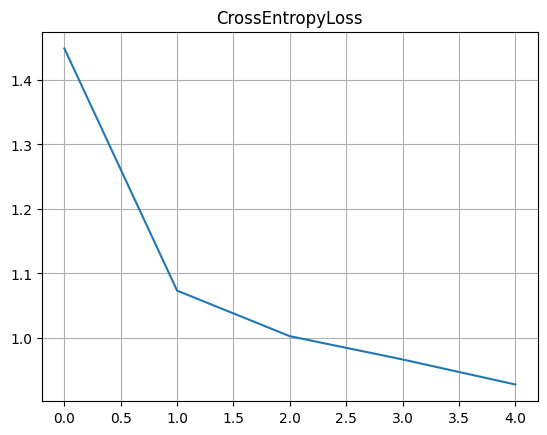

In [10]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

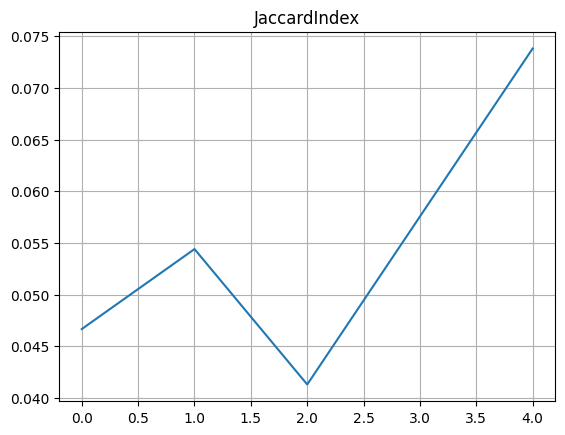

In [11]:
plt.title('JaccardIndex')
plt.plot(test_metrics)
plt.grid(True)
plt.show()

# Задача 2

Обучите модель u-net семантической сегментации на встроенном в torchvision датасете Pascal VOC с ResNet в качестве энкодера

In [12]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=21,
)

In [13]:
criterion = th.nn.CrossEntropyLoss(ignore_index=255)
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
metric = M.JaccardIndex(
    task='multiclass',
    num_classes=21,
    average='macro',
    ignore_index=255)

In [14]:
epoch_losses, test_metrics = train_model(
    model, criterion, optimizer, metric,
    file_name, train_ds, test_ds, batch_size, num_epochs)

Epoch 1/5 — train loss: 1.4362, val score: 0.0449


Epoch 2/5 — train loss: 1.0675, val score: 0.0505


Epoch 3/5 — train loss: 0.9896, val score: 0.0691


Epoch 4/5 — train loss: 0.9585, val score: 0.0566


Epoch 5/5 — train loss: 0.9225, val score: 0.0762


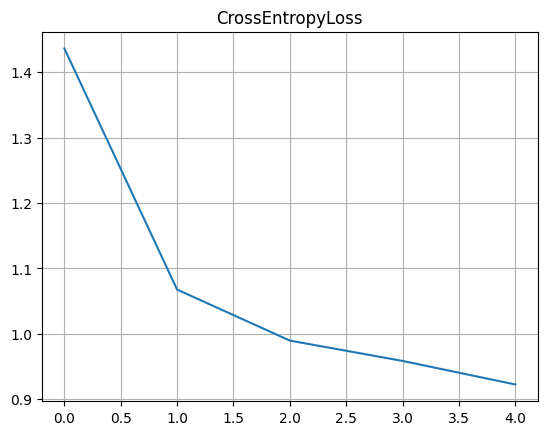

In [15]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

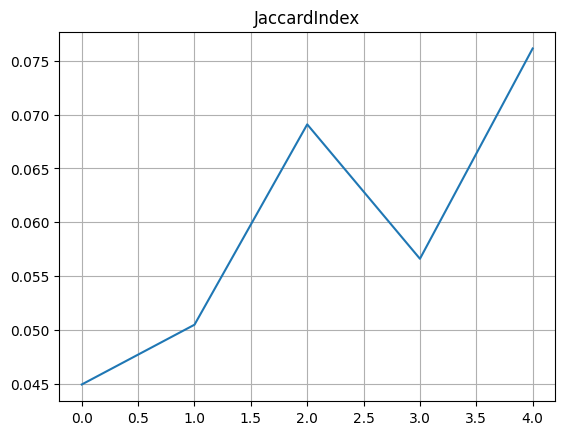

In [16]:
plt.title('JaccardIndex')
plt.plot(test_metrics)
plt.grid(True)
plt.show()

# Задача 3

Реализуйте семантическую сегментацию на предобученной Yolo

In [17]:
!pip install ultralytics >> None

In [18]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

model = YOLO('yolov8n-seg.pt')

def segment_image_yolo(img_path: str):
    img_bgr = cv2.imread(img_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    results = model(img, imgsz=640)[0]

    masks = results.masks.data.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)
    scores = results.boxes.conf.cpu().numpy()

    H, W = masks.shape[1:]
    sem_seg = np.zeros((H, W), dtype=np.int32)
    for mask, cls, score in zip(masks, classes, scores):
        sem_seg[mask > 0.5] = cls

    return img, sem_seg


0: 448x640 2 persons, 1 couch, 1 cell phone, 103.0ms
Speed: 6.0ms preprocess, 103.0ms inference, 94.5ms postprocess per image at shape (1, 3, 448, 640)


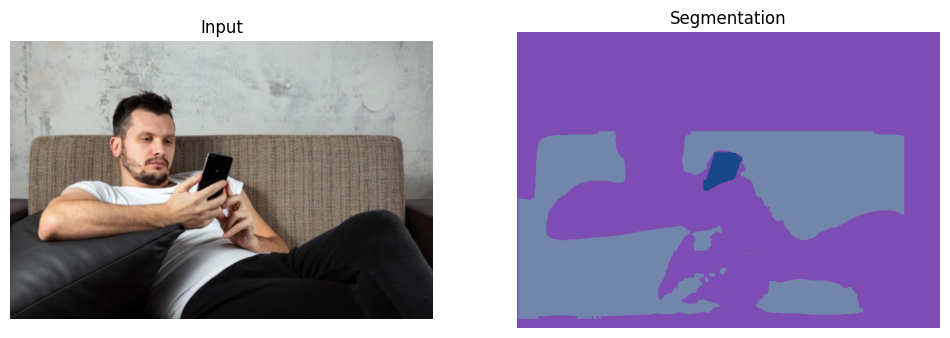

In [19]:
img, sem_seg = segment_image_yolo('/content/1790069.jpeg')

palette = np.random.randint(0, 255, (model.names.__len__(), 3), dtype=np.uint8)
colored = palette[sem_seg]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title('Input')
ax[0].axis('off')
ax[1].imshow(colored)
ax[1].set_title('Segmentation')
ax[1].axis('off')
plt.show()